Using CasJobs to query SDSS data

In [153]:
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os
import pandas as pd
import sys
import json
import functions

from io import StringIO
from io import BytesIO
import time
from datetime import datetime, timedelta     # date and timestamp tools
from pprint import pprint
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define login Name and password before running these examples
Authentication_loginName = 'snegussie'
Authentication_loginPassword = 'kokjed-4sogvy-bIhxyd'

Authentication_login_sharedWithName = '***'
Authentication_login_sharedWithPassword = '***'

#getting token
token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword)
print("token1 = " + token1)
user = Authentication.getKeystoneUserWithToken(token1)
iden = Authentication.identArgIdentifier()
print("userName = ", user.userName, "id = ", user.id, "ident = ", iden)


token1 = c2d726dcfa45409bbdf7544636eebe02
userName =  snegussie id =  3bd62d3d73654e318ecd7c375a40e27e ident =  --ident=


In [154]:
#Defining databse context and query, and other variables
CasJobs_TestDatabase = "MyDB"
CasJobs_TestQuery = "select 4 as Column1, 5 as Column2 "
CasJobs_TestTableName1 = "MyNewtable1"
CasJobs_TestTableName2 = "MyNewtable2"
CasJobs_TestTableCSV = u"Column1,Column2\n4,5\n"
CasJobs_TestFitsFile = "SciScriptTestFile.fits"
CasJobs_TestCSVFile = "SciScriptTestFile.csv"

#get user schema info
casJobsId = CasJobs.getSchemaName()
#print(casJobsId)

#get info about tables inside MyDB database context:
tables = CasJobs.getTables(context="MyDB")
print(tables)

#execute a quick SQL query:
df = CasJobs.executeQuery(sql=CasJobs_TestQuery, context=CasJobs_TestDatabase, format="pandas")
#print(df)


[{'Name': 'QuickResults', 'Rows': 2, 'Size': 136, 'Date': 637940143472400000}, {'Name': 'MyNewtable1', 'Rows': 1, 'Size': 72, 'Date': 637940915453200000}, {'Name': 'hugetable', 'Rows': 1000000, 'Size': 73480, 'Date': 637944631111770000}]


In [40]:
#submit a job, which inserts the query results into a table in the MyDB database context. 
#Wait until the job is done and get its status.
jobId = CasJobs.submitJob(sql=CasJobs_TestQuery + " into MyDB." + CasJobs_TestTableName1, context="MyDB")
jobDescription = CasJobs.waitForJob(jobId=jobId, verbose=False)
#print(jobId)
#print(jobDescription)

In [41]:
#execute a query and write a local Fits file containing the query results:
result = CasJobs.writeFitsFileFromQuery(fileName=CasJobs_TestFitsFile, queryString=CasJobs_TestQuery, context="MyDB")
#print(result)

#get a Pandas dataframe containing the results of a query
df = CasJobs.getPandasDataFrameFromQuery(queryString=CasJobs_TestQuery, context=CasJobs_TestDatabase)
#print(df)

Here is to get an image


In [42]:
#defining sql query and SDSS data relelease:
SkyServer_TestQuery = "select top 1 specobjid, ra, dec from specobj order by specobjid"
SkyServer_DataRelease = "DR17"

Here is where I input the files

In [53]:
galaxiesFull = pd.read_csv("galaxies_full.csv", sep = ',')  
raGalaxies = galaxiesFull["RA(deg)"] #right ascention
decGalaxies = galaxiesFull["DEC(deg)"] #decllination
#PosErr_Galaxies = galaxiesFull.iloc[:, 4] #position error
#PosErr_Galaxies
decGalaxies

0        9.41356
1        8.03711
2        7.47795
3       15.70974
4        6.09701
          ...   
1568     4.24299
1569    14.58182
1570     6.80593
1571     9.42611
1572    14.50000
Name: DEC(deg), Length: 1573, dtype: float64

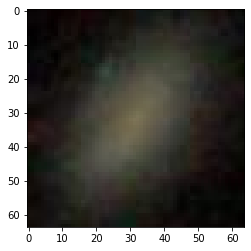

In [157]:
#get an image cutout
i = 700
 

In [57]:
# do a radial search of objects:
#arcmins

df = SkyServer.radialSearch(ra=raGalaxies[i], dec=decGalaxies[i], radius=0.1, dataRelease=SkyServer_DataRelease)
print(df)

                 objid   run  rerun  camcol  field  obj  type          ra  \
0  1237661070318567667  3631    301       5    171  243     3  141.910813   
1  1237661070318567669  3631    301       5    171  245     6  141.911262   

         dec         u         g         r         i         z     Err_u  \
0  11.620700  17.70442  16.45988  15.92774  15.67661  15.51535  0.081845   
1  11.619755  22.60935  22.77543  22.77588  23.23243  22.24078  0.202385   

      Err_g     Err_r     Err_i     Err_z  
0  0.009427  0.007206  0.011533  0.022483  
1  0.150267  0.225606  0.430979  0.480701  


Help on module SciServer.CasJobs in SciServer:

NAME
    SciServer.CasJobs

CLASSES
    builtins.object
        Task
    
    class Task(builtins.object)
     |  The class TaskName stores the name of the task that executes the API call.
     |  
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
     |  
     |  ----------------------------------------------------------------------
     |  Data and other attributes defined here:
     |  
     |  name = None

FUNCTIONS
    cancelJob(jobId)
        Cancels a job already submitted.
        
        :param jobId: id of job (integer)
        :return: Returns True if the job was canceled successfully.
        :raises: Throws an exception if the user is not logged into SciServer (use Authentication.login for that purpose). Throws an exception if the HTTP request to the CasJobs API

In [160]:
bigtablename = 'mytable'

# Example of a longer query: get magnitudes and sizes (Petrosian radii) of one million galaxies
verylongquery = 'select top 10 objid, ra, dec \n'
#verylongquery = 'ra 197.614455642896 dec 18.438168853724 \n'
#verylongquery += 'u, g, r, i, z, err_u, err_g, err_r, err_i, err_z, petror90_r \n'
verylongquery += 'modelMag_g, modelMag_r, modelMag_i, \n'
verylongquery += 'into mydb.' + bigtablename + '\n'
verylongquery += 'from galaxy\n'
verylongquery += 'where clean = 1'

print('Submitting query:\n',verylongquery)
print('\n')

thisjobid = CasJobs.submitJob(sql=verylongquery, context="DR14")

print('Job submitted with jobId = ',thisjobid)
print('\n')

waited = CasJobs.waitForJob(jobId=thisjobid)      # waited is a dummy variable; just print wait msg
jobDescription = CasJobs.getJobStatus(thisjobid)

print('\n')
print('Information about the job:')

#pprint(jobDescription)
jobDescriber(jobDescription)

Submitting query:
 select top 10 objid, ra, dec 
modelMag_g, modelMag_r, modelMag_i, 
into mydb.mytable
from galaxy
where clean = 1


Job submitted with jobId =  56384152




Information about the job:
JobID:  56384152
Status:  Failed  ( 4 )
Target (context being searched):  DR14
Message:  Incorrect syntax near the keyword 'from'.
Created_Table:  mytable
Rows:  None
Wait time:  3  seconds
Query duration:  0 seconds


In [104]:
#CasJobs.executeQuery(sql= verylongquery,context='hugetable')
# modelMag_g, modelMag_r, modelMag_i , cModelMag_g, cModelMag_r, cModelMag_i, deVMag_g, deVMag_r, deVMag_i, petroMag_g, petroMag_r, petroMag_i, petroRad_g, petroRad_r, petroRad_i
tables = SkyQuery.listDatasetTables("hugetable")

pprint(tables)

Exception: Error when listing tables in dataset hugetable.
Http Response from SkyQuery API returned status code 404:
{"restError":{"LogEventID":"00000000-0000-0000-0000-000000000000","Message":"The given key was not present in the dictionary.","StackTrace":"   at Jhu.Graywulf.Components.LazyDictionary`2.get_Item(TKey key) in C:\\Data\\dobos\\project\\skyquery-all-v1.3\\graywulf\\dll\\Jhu.Graywulf.Components\\Components\\LazyDictionary.cs:line 140\u000d\u000a   at Jhu.Graywulf.Web.Api.V1.SchemaService.GetDatasetInternal(String datasetName) in C:\\Data\\dobos\\project\\skyquery-all-v1.3\\graywulf\\dll\\Jhu.Graywulf.Web.Api\\Web\\Api\\V1\\Services\\SchemaService.cs:line 105\u000d\u000a   at Jhu.Graywulf.Web.Api.V1.SchemaService.ListTables(String datasetName) in C:\\Data\\dobos\\project\\skyquery-all-v1.3\\graywulf\\dll\\Jhu.Graywulf.Web.Api\\Web\\Api\\V1\\Services\\SchemaService.cs:line 136\u000d\u000a   at SyncInvokeListTables(Object , Object[] , Object[] )\u000d\u000a   at System.ServiceModel.Dispatcher.SyncMethodInvoker.Invoke(Object instance, Object[] inputs, Object[]& outputs)\u000d\u000a   at Jhu.Graywulf.Web.Services.RestOperationInvoker.Invoke(Object instance, Object[] inputs, Object[]& outputs) in C:\\Data\\dobos\\project\\skyquery-all-v1.3\\graywulf\\dll\\Jhu.Graywulf.Web\\Web\\Services\\RestOperationInvoker.cs:line 49","Type":"System.Collections.Generic.KeyNotFoundException"}}

In [68]:
#CasJobs functions

import SciServer
from SciServer import CasJobs     # Communicate between SciServer Compute and CasJobs
print('Imported SciServer modules')

import pandas                                # data analysis tools
import numpy as np                           # numerical tools
from datetime import datetime, timedelta     # date and timestamp tools
from pprint import pprint                    # print human-readable output
print('Imported other needed modules')


# PYTHON CONVENIENCE FUNCTIONS USEFUL FOR WORKING WITH CASJOBS

def tables_formatted(tables):   # better formatted printing of a tables dictionary (output of get_tables)
# Returns the following information about the tables in your MyDB (as a Python dictionary object):
### Size: size of the table (in kB)
### Name: the name of the table
### Rows: the number of rows the table contains
### Date: the date of the table's creation, as the number of 10-microsecond intervals elapsed 1 AD

    import pandas
    from datetime import datetime
    
    tables = sorted(tables, key=lambda k: k['Name']) # alphabetize by table name
    
    for thistable in tables:
        print('Table name:\t',thistable['Name'])
        print('Rows:\t\t {:,.0f}'.format(thistable['Rows']))
        print('Size (kB):\t {:,.0f} '.format(thistable['Size']))

        cjCreateDate = thistable['Date']
        createsec = cjCreateDate / 10000000  # Divide by 10 million to get seconds elapsed since 1 AD
        firstday = datetime(1, 1, 1, 0, 0)   # Save 1 AD as "firstday"
        created = firstday + timedelta(seconds=createsec)  # Get calendar date on which table was created     
        print('Created time:\t',created.strftime('%Y-%m-%d %H:%M:%S'))
        print('\n')
        

def jobDescriber(jobDescription):
    # Prints the results of the CasJobs job status functions in a human-readable manner
    # Input: the python dictionary returned by getJobStatus(jobId) or waitForJob(jobId)
    # Output: prints the dictionary to screen with readable formatting
    import pandas
    
    if (jobDescription["Status"] == 0):
        status_word = 'Ready'
    elif (jobDescription["Status"] == 1):
        status_word = 'Started'
    elif (jobDescription["Status"] == 2):
        status_word = 'Cancelling'
    elif (jobDescription["Status"] == 3):
        status_word = 'Cancelled'
    elif (jobDescription["Status"] == 4):
        status_word = 'Failed'
    elif (jobDescription["Status"] == 5):
        status_word = 'Finished'
    else:
        status_word = 'Status not found!!!!!!!!!'

    print('JobID: ', jobDescription['JobID'])
    print('Status: ', status_word, ' (', jobDescription["Status"],')')
    print('Target (context being searched): ', jobDescription['Target'])
    print('Message: ', jobDescription['Message'])
    print('Created_Table: ', jobDescription['Created_Table'])
    print('Rows: ', jobDescription['Rows'])
    wait = pandas.to_datetime(jobDescription['TimeStart']) - pandas.to_datetime(jobDescription['TimeSubmit'])
    duration = pandas.to_datetime(jobDescription['TimeEnd']) - pandas.to_datetime(jobDescription['TimeStart'])
    print('Wait time: ',wait.seconds,' seconds')
    print('Query duration: ',duration.seconds, 'seconds')
        
print('Created functions')

Imported SciServer modules
Imported other needed modules
Created functions


NameError: name 'hugetable' is not defined

In [98]:
jobDescription["Query"]

'ra=179.689293, dec=-0.454379 \nmodelMag_g, modelMag_r, modelMag_i, cModelMag_g, cModelMag_r, cModelMag_i, deVMag_g, deVMag_r, deVMag_i, petroMag_g, petroMag_r, petroMag_i, petroRad_g, petroRad_r, petroRad_i \ninto mydb.hugetable\nfrom galaxy\nwhere clean = 1'

In [100]:
this_context = "MyDB"    # Your MyDB
#this_context = 'dr14'   # SDSS Data Release 14

tables = CasJobs.getTables(context=this_context)
print('Tables in '+this_context+':\n')


#pprint(tables)   # Standard human-readable printing using Python's pprint module
tables_formatted(tables)  # Sorting and better printing using a convenience function

Tables in MyDB:

Table name:	 MyNewtable1
Rows:		 1
Size (kB):	 72 
Created time:	 2022-07-22 12:59:05


Table name:	 QuickResults
Rows:		 2
Size (kB):	 136 
Created time:	 2022-07-21 15:32:27




In [132]:
info = SkyQuery.getDatasetInfo("hugetable")
print(info)

Exception: Error when getting info from dataset hugetable.
Http Response from SkyQuery API returned status code 500:
{"restError":{"LogEventID":"00000000-0000-0000-0000-000000000000","Message":"Access is denied.","StackTrace":"   at System.ServiceModel.Dispatcher.SyncMethodInvoker.Invoke(Object instance, Object[] inputs, Object[]& outputs)\u000d\u000a   at Jhu.Graywulf.Web.Services.RestOperationInvoker.Invoke(Object instance, Object[] inputs, Object[]& outputs) in C:\\Data\\dobos\\project\\skyquery-all-v1.3\\graywulf\\dll\\Jhu.Graywulf.Web\\Web\\Services\\RestOperationInvoker.cs:line 49","Type":"System.ServiceModel.FaultException"}}

In [151]:
object = SkyServer.objectSearch(ra=258.25, dec=64.05, dataRelease="DR17", query = 'r, i ')


TypeError: objectSearch() got an unexpected keyword argument 'query'

In [152]:
help(SkyServer.objectSearch)

Help on function objectSearch in module SciServer.SkyServer:

objectSearch(objId=None, specObjId=None, apogee_id=None, apstar_id=None, ra=None, dec=None, plate=None, mjd=None, fiber=None, run=None, rerun=None, camcol=None, field=None, obj=None, dataRelease=None)
    Gets the properties of the the object that is being searched for. Search parameters:
    
    
    :param objId: SDSS ObjId.
    
    :param specObjId: SDSS SpecObjId.
    
    :param apogee_id: ID idetifying Apogee target object.
    
    :param apstar_id: unique ID for combined apogee star spectrum.
    
    :param ra: right ascention.
    
    :param dec: declination.
    
    :param plate: SDSS plate number.
    
    :param mjd: Modified Julian Date of observation.
    
    :param fiber: SDSS fiber number.
    
    :param run: SDSS run number.
    
    :param rerun: SDSS rerun number.
    
    :param camcol: SDSS camera column.
    
    :param field: SDSS field number.
    
    :param obj: The object id within a field.


In [156]:
params = {
    
    "modelMag_g, modelMag_r, modelMag_i,cModelMag_g, cModelMag_r, cModelMag_i, petroMag_g, petroMag_r, petroMag_i, petroRad_g, petroRad_r, petroRad_i"

}

In [158]:
SciServer.CasJobs.getNumpyArrayFromQuery(ra=raGalaxies[i], dec=decGalaxies[i],queryString= params, context='MyDB')



TypeError: getNumpyArrayFromQuery() got an unexpected keyword argument 'ra'

In [161]:
bigtablename = 'hugetable'

# Example of a longer query: get magnitudes and sizes (Petrosian radii) of one million galaxies
verylongquery = 'select top 1000000 objid, ra, dec \n'
verylongquery += 'u, g, r, i, z, err_u, err_g, err_r, err_i, err_z, petror90_r \n'
verylongquery += 'into mydb.' + bigtablename + '\n'
verylongquery += 'from galaxy\n'
verylongquery += 'where clean = 1'

print('Submitting query:\n',verylongquery)
print('\n')

thisjobid = CasJobs.submitJob(sql=verylongquery, context="DR14")

print('Job submitted with jobId = ',thisjobid)
print('\n')

waited = CasJobs.waitForJob(jobId=thisjobid)      # waited is a dummy variable; just print wait msg
jobDescription = CasJobs.getJobStatus(thisjobid)

print('\n')
print('Information about the job:')

#pprint(jobDescription)
jobDescriber(jobDescription)

Submitting query:
 select top 1000000 objid, ra, dec 
u, g, r, i, z, err_u, err_g, err_r, err_i, err_z, petror90_r 
into mydb.hugetable
from galaxy
where clean = 1


Job submitted with jobId =  56384164




Information about the job:
JobID:  56384164
Status:  Failed  ( 4 )
Target (context being searched):  DR14
Message:  There is already an object named 'hugetable' in the database.
Created_Table:  None
Rows:  None
Wait time:  5  seconds
Query duration:  0 seconds


In [163]:
tables = SciServer.SciDrive.download("hugetable")

Exception: Error when getting the public URL of SciDrive file hugetable.
Http Response from SciDrive API returned status code 404:
{
  "error" : "/hugetable"
}